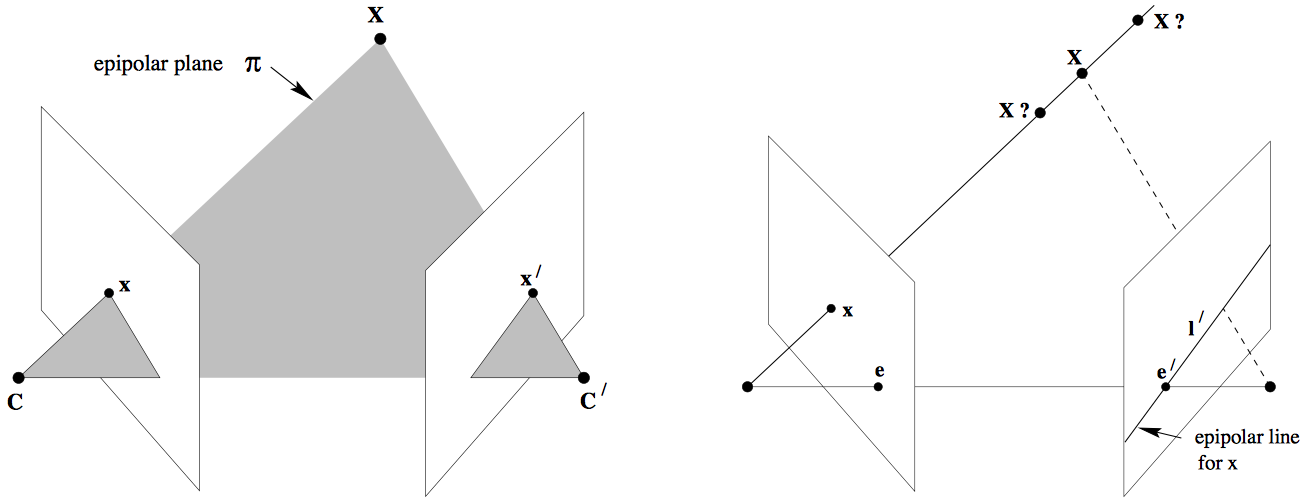# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

1. trouver les coins des chessboards
2. assigner des points 3D aux points du chessboard
3. "calibration" pour chaque camera
	= matrice intrinseque, coefficients de distortion, vecteurs de rotation, vecteurs de translation
4. "stereo-calibration"
	= matrice fondamentale (,matrice de rotation)
5. trouver les points du laser
6. trouver les lignes epipolaires correspondant aux point du laser
7. intersection entre epipolaires et lasers = x'
8. matrices de projection
9. trianguler les points
10. reprojeter

## Imports

In [156]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math
import os

## Chessboard Corner detection

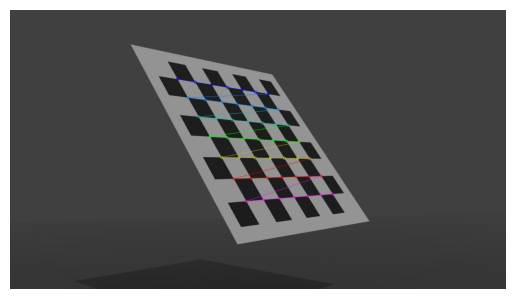

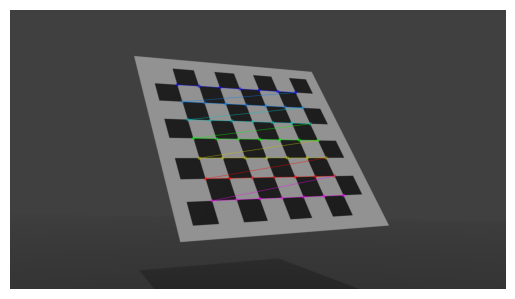

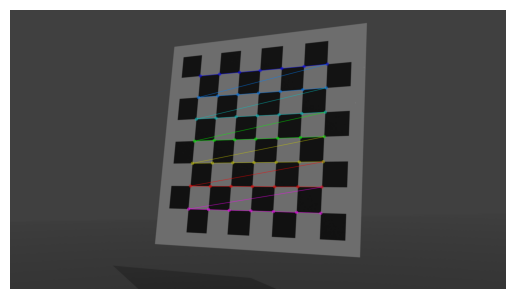

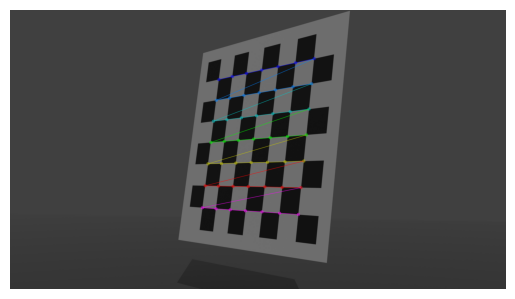

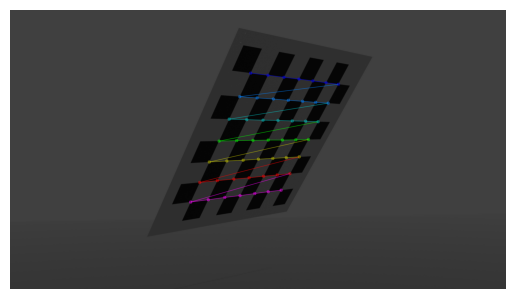

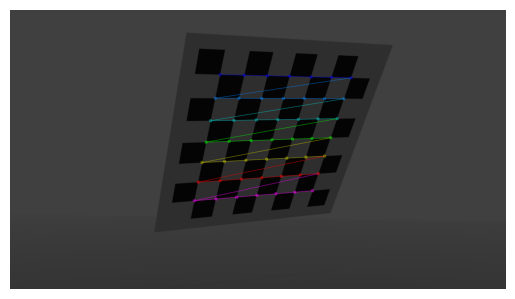

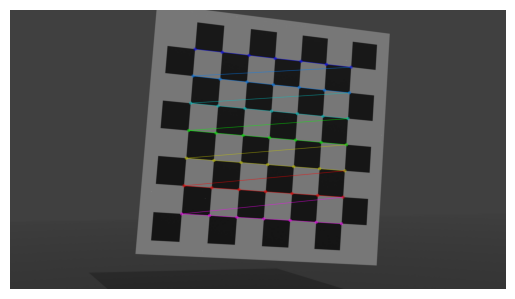

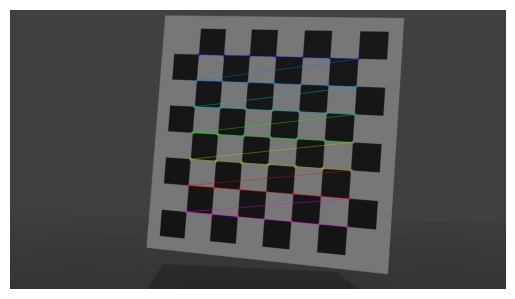

In [157]:
CHESS_DIMENSIONS = (7,7) #dimension intérieur du chessboard

#X c'est un object point, x est un image point
#l'image point c'est la coordonnée sur l'miage et l'obect point c'est le ppoint en 3D
def correction_rotation(corners):
    """Tourne tout les points d'une image du chessboard de 90° car certaines images sont bugés

    Args:
        corners: liste de la coordonnée 2D (ximage x yimage) de chaque corner du chessboard

    Returns:
        corners_corrected: liste de la coordonnée 2D (ximage x yimage) de chaque corner du chessboard mais tourné de 90°
    """
    corners_corrected = np.copy(corners)
    i = 0
    for j in range(0,7):
        for k in range(6,-1,-1):
            corners_corrected[i] = corners[j+(7*k)]
            i += 1
    return corners_corrected


def darker_chessboard(img_file):
    """Fonction trouvé sur StackOverFlow qui permet de trouver les corners sur les formes ombrés

    Args:
        img_file: image chessboard

    Returns:
        res: image chessboard améliorée
    """
    img = cv2.imread(img_file)
    # Color-segmentation to get binary mask
    lwr = np.array([0, 0, 4]) #black
    upr = np.array([0, 0, 13]) #"white" (actually grey)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    msk = cv2.inRange(hsv, lwr, upr)

    # Extract chess-board
    krn = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 30))
    dlt = cv2.dilate(msk, krn, iterations=5)
    res = 255 - cv2.bitwise_and(dlt, msk)

    # return accurate chess-board features
    res = np.uint8(res)
    return res


def detect_chess_corners(img_file):
    """Detection des corners d'un chessboard

    Args:
        img_file: image chessboard

    Raises:
        Exception: Fonction open cv "findChessboardCorners" ne trouve pas de corner sur une photo 

    Returns:
        upgrade_corners: Listes des coordonées des corners d'un chessboard
    """
    img = cv2.imread(img_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    returned, corners = cv2.findChessboardCorners(gray, (CHESS_DIMENSIONS[0],CHESS_DIMENSIONS[1]), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK) #image, dimension interieur du chessboard (carreau) 7x7 intyerieur, pius d'autre -> return la position des corners sur l'image (2D)

    if not returned: #si l'image est trop sombre
        returned, corners = cv2.findChessboardCorners(darker_chessboard(img_file), (CHESS_DIMENSIONS[0],CHESS_DIMENSIONS[1]), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK)
        if not returned:
            raise Exception(f"No corners on this photo : {img_file}")

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    upgrade_corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria) #pour améliorer la résolution du résultat du detectchesscorners, ca détecte mieux les coins grâce à un gradient
    file_to_rotate = ["2L","2R","3L"] #noms des fichiers ou les points sont reliés avec le mauvais angle

    if any(x in img_file for x in file_to_rotate):
        return correction_rotation(upgrade_corners) #on corige à la main le fait que le truc soit à 90degré
    else:
        return upgrade_corners

def draw_chess_corners(img_file, corners): #permet de dessiner les corners les lier, puis de plot l'image
    """Dessiner les chessboard avec les corners qu'on a trouvée

    Args:
        img_file: images du chessboard
        corners: coordonnées 2D des corners du chessboard
    """
    img = cv2.imread(img_file)
    cv2.drawChessboardCorners(img, (CHESS_DIMENSIONS[0],CHESS_DIMENSIONS[1]), corners, True) #image , dimension, position des corners (2D), True pour les draw
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def test_chess_corners(img_file):
    draw_chess_corners(img_file, detect_chess_corners(img_file))

directory = 'chessboards'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        test_chess_corners(f)

## Calibration

In [158]:
RESOLUTION = (1920, 1080)
objp = np.zeros((CHESS_DIMENSIONS[0]*CHESS_DIMENSIONS[1],3), np.float32) #on créer l'axe et on assignie 0,0,0 à l'origine etc
objp[0:,:2] = np.mgrid[0:CHESS_DIMENSIONS[0],0:CHESS_DIMENSIONS[1]].T.reshape(-1,2) #matriice de 000 100 200 jujsque 666 qui représente chaque poinnts mais en 3D pour chaquqe image
left_images = glob.glob('./chessboards/*Left.png') #all chessboard images
right_images = glob.glob('./chessboards/*Right.png') #all chessboard images
print(objp)

def calibrate():
    """Calibration des 2 caméras avec les chessboards pour trouver les matrices utiles à la suite de l'exercice permettant le lien entre les points 3D et 2D.

    Returns:
        fundamental_matrix, \ncommon = [rotation_matrix, translation_vector, essential_matrix], \n left_calibration = [left_projection_matrix, left_dist_coeffs, left_rotation_vecs, left_translation_vecs], \nright_calibration = [right_projection_matrix, right_dist_coeffs, right_rotation_vecs, right_translation_vecs]
    """
    #define the world coordinates for 3D points = prepare object points, like (0,0,0), (1,0,0), ... (6,6,0)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    
    ######### LEFT ##########
    left_imgpoints = [] # 2d points in image plane.
    ######### RIGHT ##########
    right_imgpoints = [] # 2d points in image plane.
    
    ######### LEFT ##########
    for img_file in left_images:
        #add object points
        objpoints.append(objp) #les images points on les attribures 0 0 0, 1 0 0, 2 0 0 etc... et on le fait que pour les images de left mais c'est les memes pour les images de right (il y en a 4x2)
        #find corners (and refine them)
        corners = detect_chess_corners(img_file)
        #add image points
        left_imgpoints.append(corners) #point en 2D

    ######### RIGHT ##########
    for img_file in right_images:
        #find corners (and refine them)
        corners = detect_chess_corners(img_file) #49 çpoints par image qu'on va utiliser pour faire la calibration
        #add image points
        right_imgpoints.append(corners) #point en 2D
    ##### CALIBRATION #####
    #individual cameras (mono x2)
    returned, left_intrinsic_matrix, left_dist_coeffs, left_rotation_vecs, left_translation_vecs = cv2.calibrateCamera(objpoints, left_imgpoints, RESOLUTION, None, None) #on lui donne 4 grilles des positions des points en 3D (objpoints), les points des corners gauches, la résolution de l'image
    returned, right_intrinsic_matrix, right_dist_coeffs, right_rotation_vecs, right_translation_vecs = cv2.calibrateCamera(objpoints, right_imgpoints, RESOLUTION, None, None)#on lui donne 4 grilles des positions des points en 3D (objpoints), les points des corners droite, la résolution de l'image

    stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC #ne pas modifier l'intrinsèque dans la fonction stereoCalibrate
    criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001) #je ne sais pas

    returnedStereo, \
    left_intrinsic, left_dist_coeffs,\
    right_intrinsic, right_dist_coeffs,\
    rotation_matrix, translation_vector, essential_matrix,\
    fundamental_matrix\
    = cv2.stereoCalibrate(objpoints, left_imgpoints, right_imgpoints, left_intrinsic_matrix, left_dist_coeffs, right_intrinsic_matrix, right_dist_coeffs, RESOLUTION, criteria = criteria_stereo, flags = stereocalibration_flags) # on choppe surtout la matrice fondamental

    #rotation matrixe permet de passer de l'une à l'autre
    #rotation vecs camera % aux axes défini
    
    left_calibration = [left_intrinsic, left_dist_coeffs, left_rotation_vecs, left_translation_vecs]
    right_calibration = [right_intrinsic, right_dist_coeffs, right_rotation_vecs, right_translation_vecs]
    common = [rotation_matrix, translation_vector, essential_matrix] #commun aux deux cameras (inutilisé dans la suite)
    return fundamental_matrix, common, left_calibration, right_calibration

def test_reprojection(fundamental_matrix, left_calibration, right_calibration):  #pour vérifier en reprojétant en arriere
    """Permet de repartir des points 3D des corners du chessboard et de projeter les points sur les caméras et donc de les rendre 2D

    Args:
        fundamental_matrix: fundamental_matrix
        left_calibration: left_calibration = [left_projection_matrix, left_dist_coeffs, left_rotation_vecs, left_translation_vecs]
        right_calibration: right_calibration = [right_projection_matrix, right_dist_coeffs, right_rotation_vecs, right_translation_vecs]
    """
    # ----- reprojection test -----
    # Verification by reprojection
    # dimensions = (7,7) #number of inner corners of the checkerboard = number of squares - 1 (=!= number of squares !!!)
    #define the world coordinates for 3D points = prepare object points, like (0,0,0), (1,0,0), ... (6,6,0)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    objpoints.append(objp)
    mean_error = 0

    ######### LEFT ##########
    for i in range(len(left_images)):
        # point 2D qu'on veut retrouver à partir des poitns 3D
        reprojection_img_points, _ = cv2.projectPoints(objpoints[0], left_calibration[2][i], left_calibration[3][i], left_calibration[0], left_calibration[1]) #2eme param = jacobienne
        # on donne les object point, résultat de la calibration et me renvoie les images des points 2D    2 left_rotation_vecs 3 left_translation_vecs 0 left_projection_matrix 1 left_dist_coeffs
        #on ne réitere pas sur le 0 et le 1 car ce soit des matrices uniques contrairement au 2 3 qui sont propre à chaue iimage

        # point 2D réel qu'on avait calculé avant
        actual_img_points = detect_chess_corners(left_images[i])
        #on regardes si les points sont proches ou non
        error = cv2.norm(actual_img_points, reprojection_img_points, cv2.NORM_L2)/len(reprojection_img_points) #on divise par le nompbre de point pour avoir la moyenne de la distance entre les deux points mais pour 1 seul images car la fonction norm fait des sommes
        print(f"{actual_img_points[11]}    ==>    {reprojection_img_points[11]}") #pour chaque image de gauche on regarde le 11 eme points
        mean_error += error

    ######### RIGHT ##########
    for i in range(len(right_images)):
        reprojection_img_points, _ = cv2.projectPoints(objpoints[0], right_calibration[2][i], right_calibration[3][i], right_calibration[0], right_calibration[1])
        actual_img_points = detect_chess_corners(right_images[i])
        error = cv2.norm(actual_img_points, reprojection_img_points, cv2.NORM_L2)/len(reprojection_img_points)
        print(f"{actual_img_points[11]}    ==>    {reprojection_img_points[11]}")
        mean_error += error

    print(f"\nTotal average error: {(mean_error/(len(left_images) + len(right_images)))}") #on divise le nombre d'erreur par le nombre d'image et on a l'ereur moyenne

fundamental_matrix, common_matrices, left_calibration, right_calibration = calibrate()
test_reprojection(fundamental_matrix, left_calibration, right_calibration)
print("\nFundamental matrix:\n", fundamental_matrix)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [0. 6. 0.]
 [1. 6. 0.]
 [2. 6. 0.]
 [3. 6. 0.]
 [4. 6. 0.]
 [5. 6. 0.]
 [6. 6. 0.]]
[[936.1365  371.40543]]    ==>    [[936.0911 371.4037]]
[[1046.3435   314.51288]]    ==>    [[1046.3317   314.50626]]
[[1131.644    352.69104]]    ==>    [[1131.6348  352.7625]]
[[1118.9777  299.2622]]    ==>    [[1118.9816   299.22073]]
[[989.5855  370.95517]]    ==>    [[989.6133  370.94135]]
[[1027.219    309.21222]]    ==>    [[1027.1779   309.17545]]
[[1139.4875  342.4188]]    ==>    [[1139.4989   342.4

## Laser lines extraction

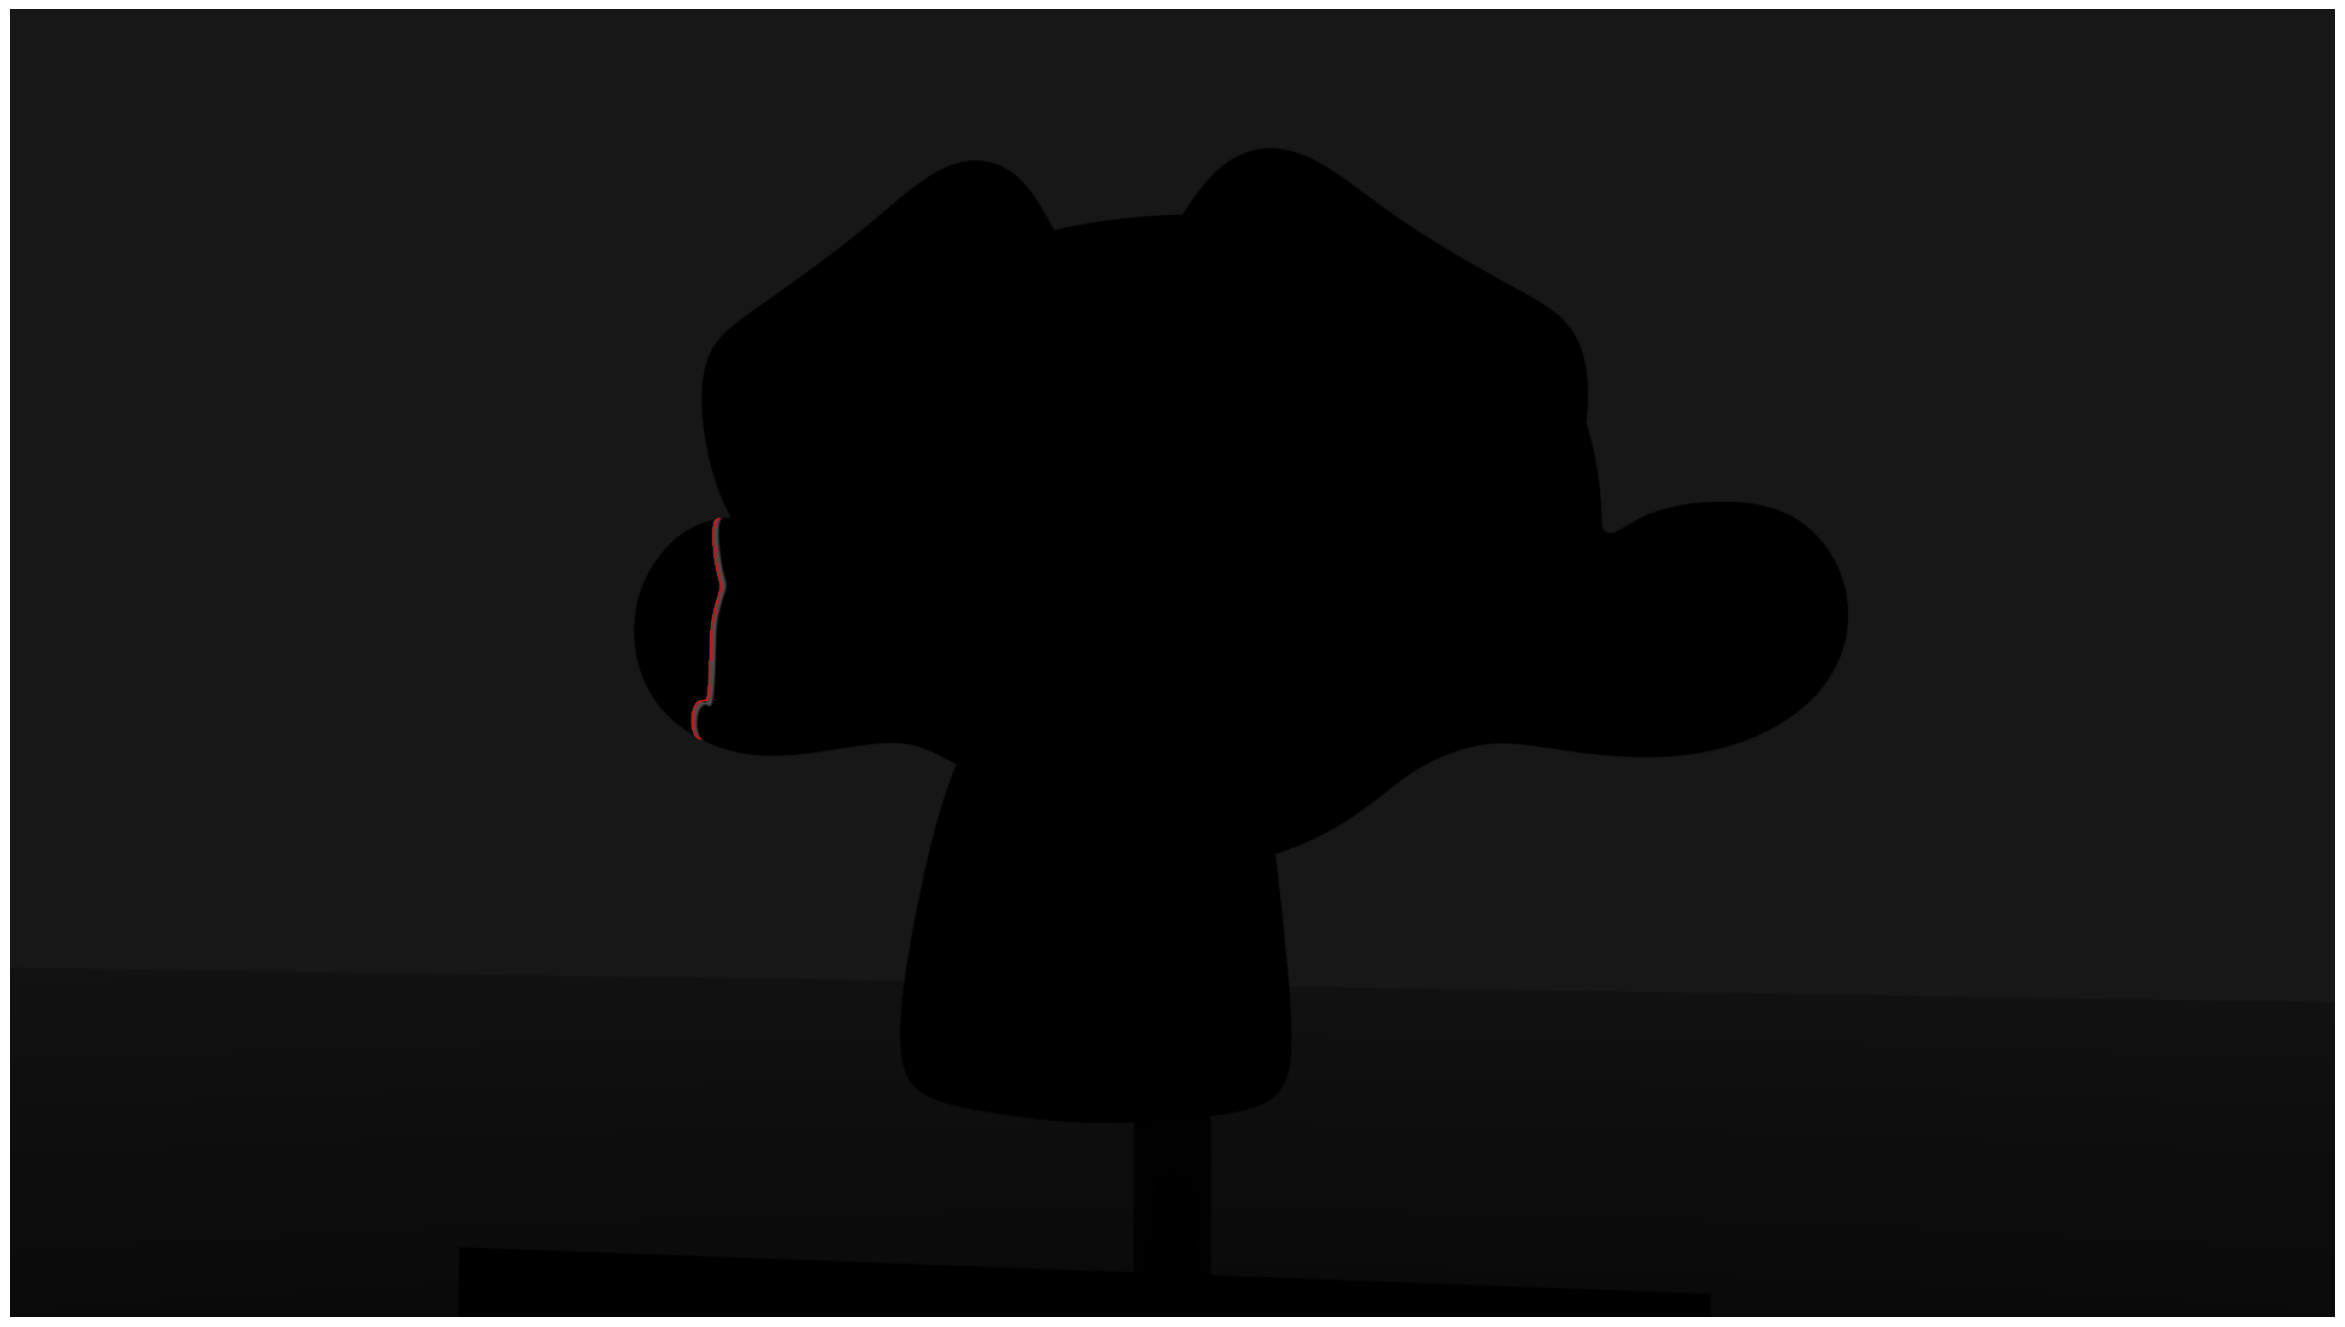

In [159]:
def binary_to_coordinates(binary):
    """Les axes x et y sont inversé alors on les réinverse avec np.flip puis on cherche tout l'index ou la valeur est 255, il y en a qu'un seul par ligne avec

    Args:
        binary: coordoonée sur chaque ligne composée de 0 et de 255 avec 1 seul 255 par ligne

    Returns:
        l'index sur chaque ligne ou se situe le 255 c'est à dire le point du laser par ligne
    """
    return np.flip(np.argwhere(binary == 255.0)) #renvoie  une array avec les coordonnées 2D de ou se situe les endroits ou y a un 255, les axes x et y sont inversé du coup on utilise flip

def extract_laser_line(img_file): #renvoie 0 0 0 255 0 0 0 0 avec un seul points à 255 possible par ligne, et ce, pour chaque ligne dans le code | Pour une seule image
    """Scan de l'image ligne par ligne pour retrouver tout les endroits ou il y a un laser pour finalement isoler que la première occurence où se trouve le laser

    Args:
        img_file: l'image du singe

    Returns:
        red_line: ensemble de 0 et de 255 par ligne où le 255 représente l'endroit où se situe le laser
    """
    img = cv2.imread(img_file)
    lowerbound = np.array([0, 0, 120])
    upperbound = np.array([100, 100, 255])
    red_band = cv2.inRange(img, lowerbound, upperbound) #trouve tout les pixels du laser en binaire 0 0 0 0 255 255 0 0 0 0
    red_line_indices = np.argmax(red_band, axis=1) #pour chaqque ligne l'indice de ou est le premier 255
    red_line = np.zeros((1080, 1920)) #de meme forme que redband mais vierge
    for column, row in enumerate(red_band):
        if row[red_line_indices[column]] != 0: #car la plus grande valeur à chaque ligne s'il n'ya paps de laser c'est tout simplement le premier pixel, or on le veut pas
            red_line[column][red_line_indices[column]] = 255
    # print(red_line)  
    return red_line

def extract_laser_lines(): # appliquons la fonction passée pour chaque image gauche et droite et sauvegardons toutes les coordonnées des lasers
    """Extraction des coordonnées ligne par ligne pour toutes les images d'où se trouve la première occurence du laser 

    Returns:
        left_lines, right_lines: coordoonnée du laser de gauche et de droite pour toutes les images, il y a donc 26 x 2 listes d'index
    """
    
    ######### LEFT ##########
    left_img_files = glob.glob("./scanLeft/*.png") #listes de toutes les images Left
    left_lines = []
    for img_file in left_img_files:
        left_lines.append(extract_laser_line(img_file)) # envoie les coordonnée de chaque points du laser pour chaque images de gauche (26 images)

    ######### RIGHT ##########
    right_img_files = glob.glob("./scanRight/*.png") # listes des toutes les images right
    right_lines = []
    for img_file in right_img_files:
        right_lines.append(extract_laser_line(img_file)) # envoie les coordonnée de chaque points du laser pour chaque images de droite (26 images)

    for i in range (0, len(left_lines)):
        left_lines[i] = binary_to_coordinates(left_lines[i]) #on transforme toute l'image en une liste de coordonnée qui forme la ligne rouge
        right_lines[i] = binary_to_coordinates(right_lines[i])
    return left_lines, right_lines #tout les coordonnée de chaque points du laser pour chaque images de gauche et de droite (les 26 images X2)


def test_laser_line_extraction(img_file):
    """Plot une image de l'extraction du laser

    Args:
        img_file: image du singe
    """
    img = cv2.imread(img_file,0)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    red_line = extract_laser_line(img_file)
    plt.figure(figsize = (30,20))
    plt.imshow(img)
    plt.axis("off")
    plt.plot(*zip(*binary_to_coordinates(red_line)), "r", linewidth=1.0)
    plt.show()

test_laser_line_extraction("scanRight/scan0020.png")

left_lasers, right_lasers = extract_laser_lines()

## Epipolar lines

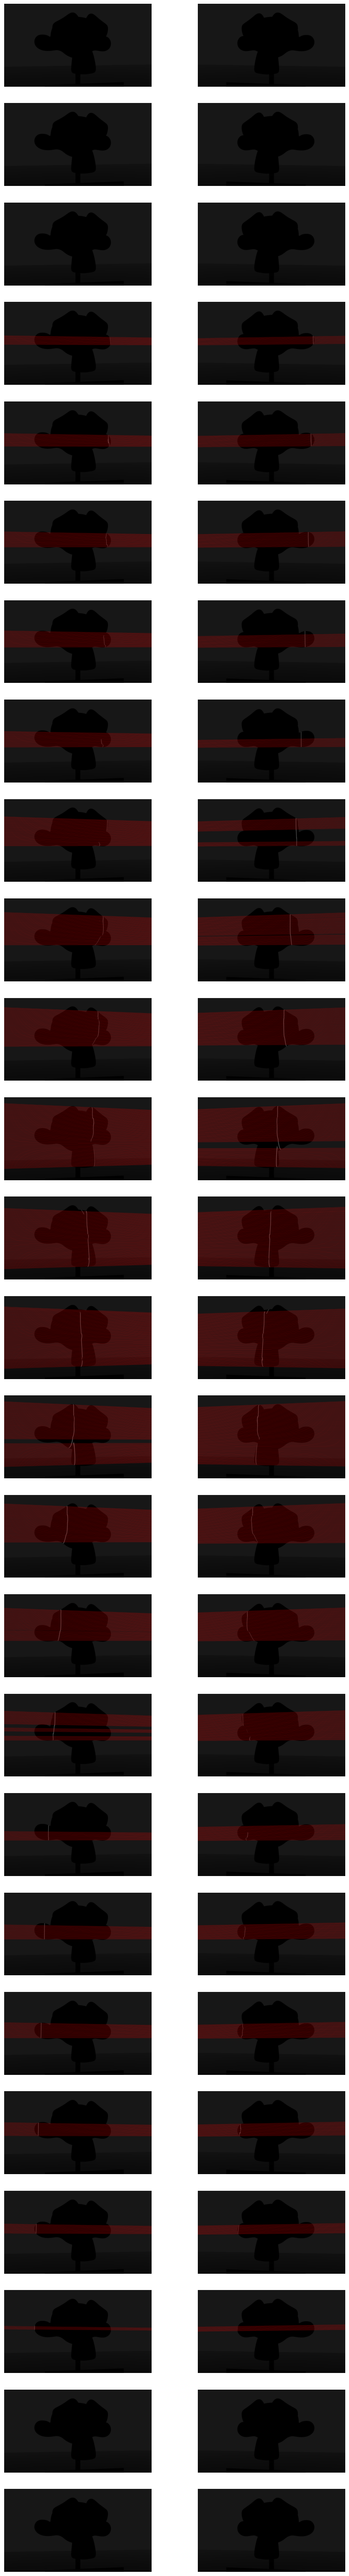

In [160]:
WIDTH = 1920

def find_epipolar_lines(points, fundamental_matrix, side): # trouver les lignes épipolaires #exemple opencv
    """Trouver la ligne épipolaire \n
    https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html#:~:text=It%20is%20called%20the%20epipole

    Args:
        points (_type_): ensemble de points du laser de gauche ou de droite
        fundamental_matrix (_type_): Matrice fondamentale
        side (_type_): 1 ou 2 qui représente soit la gauche soit la droite

    Returns:
        _type_: a, b, c étant les paramètres d'une droite épipolaire
    """
    epipolar_lines = cv2.computeCorrespondEpilines(points.reshape(-1,1,2), side, fundamental_matrix) # je donne les points du laser, la matrice fondamental, (1 ou 2 pour gauche ou droite). renvoie 3 constante pour faire une droite a b c
    return (epipolar_lines.reshape(-1,3))

def show_epipolar_lines(left_lasers, right_lasers): #left__lasers = tout les coordonnée de chaque points du laser pour chaque images de gauche (26)
    """Parcourir toutes les images de singes de droite et de gauche pour plot sur chacun d'entre eux, les ensembles de droite épipolaires.

    Args:
        left_lasers: coordonnée ligne par ligne de l'index des points formant le laser de gauche
        right_lasers: coordonnée ligne par ligne de l'index des points formant le laser de gauche
    """
    plt.figure(figsize = (11,80)) #résolution de l'image
    ##### IMAGES #####
    for index in range(0,26): #je boucle sur toute les images
        if index < 10: #pour le nom des photos
            left_img = cv2.imread((f"scanLeft/000{index}.png"),0) #ca c'est une image
            right_img = cv2.imread(f"scanRight/scan000{index}.png",0) 
        else:
            left_img = cv2.imread(f"scanLeft/00{index}.png",0)
            right_img = cv2.imread(f"scanRight/scan00{index}.png",0)
        left_img = cv2.cvtColor(left_img,cv2.COLOR_GRAY2BGR) #je la met en noir et blanc car en couleur c'est moche 
        right_img = cv2.cvtColor(right_img,cv2.COLOR_GRAY2BGR)
        ##### EPIPOLAR LINES #####
        left_points = left_lasers[index] #quand index = 0 c'est les coordonnées du laser de la premiere image, etc
        right_points = right_lasers[index]
        
        if len(left_points) > 0 and len(right_points) > 0:  #avoid bugs when lists are empty, if there aren't points for this image
            left_epipolar_lines = find_epipolar_lines(right_points, fundamental_matrix, 2) # on voit tres bien que la left epipolar se trouve avec les points de droite, chaque point du laser de droite
            right_epipolar_lines = find_epipolar_lines(left_points, fundamental_matrix, 1) #chaque point du laser de gauche
            ##### display #####
            iteration = 0
            for left_line in left_epipolar_lines:
                if iteration % 5 == 0:  #we skip every few lines so the image behind them is still visible
                    # LEFT
                    x0,y0 = map(int, [0, -left_line[2]/left_line[1] ])
                    x1,y1 = map(int, [WIDTH, -(left_line[2]+left_line[0]*WIDTH)/left_line[1] ])
                    left_img = cv2.line(left_img, (x0,y0), (x1,y1), (255,0,0),1)
                iteration += 1
            for right_line in right_epipolar_lines:
                if iteration % 5 == 0:  #we skip every few lines so the image behind them is still visible
                    # LEFT
                    x0,y0 = map(int, [0, -right_line[2]/right_line[1] ])
                    x1,y1 = map(int, [WIDTH, -(right_line[2]+right_line[0]*WIDTH)/right_line[1] ])
                    right_img = cv2.line(right_img, (x0,y0), (x1,y1), (255,0,0),1)
                iteration += 1
            # laser lines
        plt.subplot(26,2,index*2+1),plt.imshow(left_img) # plot l'image de gauche et tu plot les points en bleu pour le laser avec une tel aparaisseur
        # plt.plot(*zip(*left_points), "b", linewidth=0.5)
        plt.axis("off")
        plt.subplot(26,2,index*2+2),plt.imshow(right_img)
        # plt.plot(*zip(*right_points), "b", linewidth=0.5)
        plt.axis("off")
    plt.show()

show_epipolar_lines(left_lasers, right_lasers) #left__lasers = tout les coordonnée de chaque points du laser pour chaque images de gauche (26)

## Intersections between epipolar lines and red laser

In [161]:
def find_close_point(line, points): #line = droite épipolaire, points = points du laser, pour une ligne épipolaire et plusieurs points
    """Trouver par quels points du laser passe une ligne épipolaire

    Args:
        line: une ligne épipolaire ayant comme paramètre (a, b, c)
        points: ensemble des coordoonnées d'un laser d'une seul image

    Returns:
        la colonne du point qui est le plus proche de la ligne épipolaire ou alors renvoie (0,0). \nOn va devoir supprimer dans les prochaines étapes car cela veut dire que nous n'avons pas de correspondance entre l'épipolaire un des points de l'image 
    """
    # A = line[0] B = line[1] C = line[2], x1 = points[0] y1 = points[1]
    closest_point = {"point" : 0, "distance" : 2202} #diagonal = points le plus possibles
    for point in points:
        distance = abs((line[0] * point[0] + line[1] * point[1] + line[2])) / (math.sqrt(line[0] * line[0] + line[1] * line[1])) # distance entre un point et une droite
        if distance < closest_point["distance"]:
            closest_point["point"] = point
            closest_point["distance"] = distance
        if distance < 0.05: #0.1 ca marche bien donc on regarde pas pour le sautres points, on réduit la complexité de toutes les  boucles
            break
    if closest_point["distance"] < 0.5:
        return closest_point["point"] #le but est de tomber sur cette condition et donc de comprendre que la ligne épipolaire qu'on a choisi touche le point trouvé sur le laser
    else:
        return np.zeros((1,2))  # Since I can't put NoneType in corresponding_right_pts, I return the point (0,0) #en 0 0 si le point ne touche aucune droite épipolaire


def remove_no_match(): #enleve la ligne a 2 element ou y a des 0 0 car c'est des lignes épipolaire qui ne touche pas le laser
    """Supprimer toutes les occurence ou le point correspondant, qui est le point proche d'une ligne épipolaire vaut 0.\nCar on avait dit que lorsqu'elle vaut 0, c'est qu'on a pas trouvé de points correspondant et que la ligne épipolaire ne passe par aucun point
    """
    for i in range(0,26):
        indices = np.where(corresponding_right_points[i] == 0) # si tu es sur un bord ca supprime forcément vu que il faut qu'il y ait juste un 0 dans la ligne
        corresponding_right_points[i] = np.delete(corresponding_right_points[i], indices, axis=0)
        left_lasers[i] = np.delete(left_lasers[i], indices, axis=0)

def corresponding_points(left_lasers, right_lasers): #renvoie image numéro n, point laser, la coordonnée x ou y
    """Trouver pour chaque image gauche et droite du singe, les points de l'image de droite qui correspondent aux points des images de gauche

    Args:
        left_lasers: coordonnée ligne par ligne de l'index des points formant le laser de gauche
        right_lasers: coordonnée ligne par ligne de l'index des points formant le laser de droite

    Returns:
        corresponding_right_points: Les points de l'image de droite qui correspondent aux points des images de gauche
    """
    #on parcours toutes les images et pour chaque images on parcours les lignes épipolaires de celle-ci et pour chaque épipolaire on fait un find_close_points pour le tester sur chaque points
    corresponding_right_points = []
    for img_index in range(0,26):
        left_points = left_lasers[img_index]
        right_points = right_lasers[img_index]
        corresponding_right_pts = np.zeros_like(left_points)
        if len(left_points) > 0 and len(right_points) > 0:  #avoid bugs when lists are empty
            left_epipolar_lines = find_epipolar_lines(right_points, fundamental_matrix, 2) #renvoie les 3 parametres d'une droite ax + by + c = 0, 2 ca veut dire droite
            right_epipolar_lines = find_epipolar_lines(left_points, fundamental_matrix, 1)
            for pnt_index in range(0, len(right_epipolar_lines)):
                corresponding_right_pts[pnt_index] = find_close_point(right_epipolar_lines[pnt_index], right_points)
        corresponding_right_points.append(corresponding_right_pts)
    print(corresponding_right_pts)
    return corresponding_right_points

corresponding_right_points = corresponding_points(left_lasers, right_lasers)
remove_no_match()

[]


## Intersection between left & right epipolar lines

In [162]:
print(left_lasers[8][0])
print(tuple(left_lasers[8][0]))
print(corresponding_right_points[8][0])

[1236  612]
(1236, 612)
[1284  611]


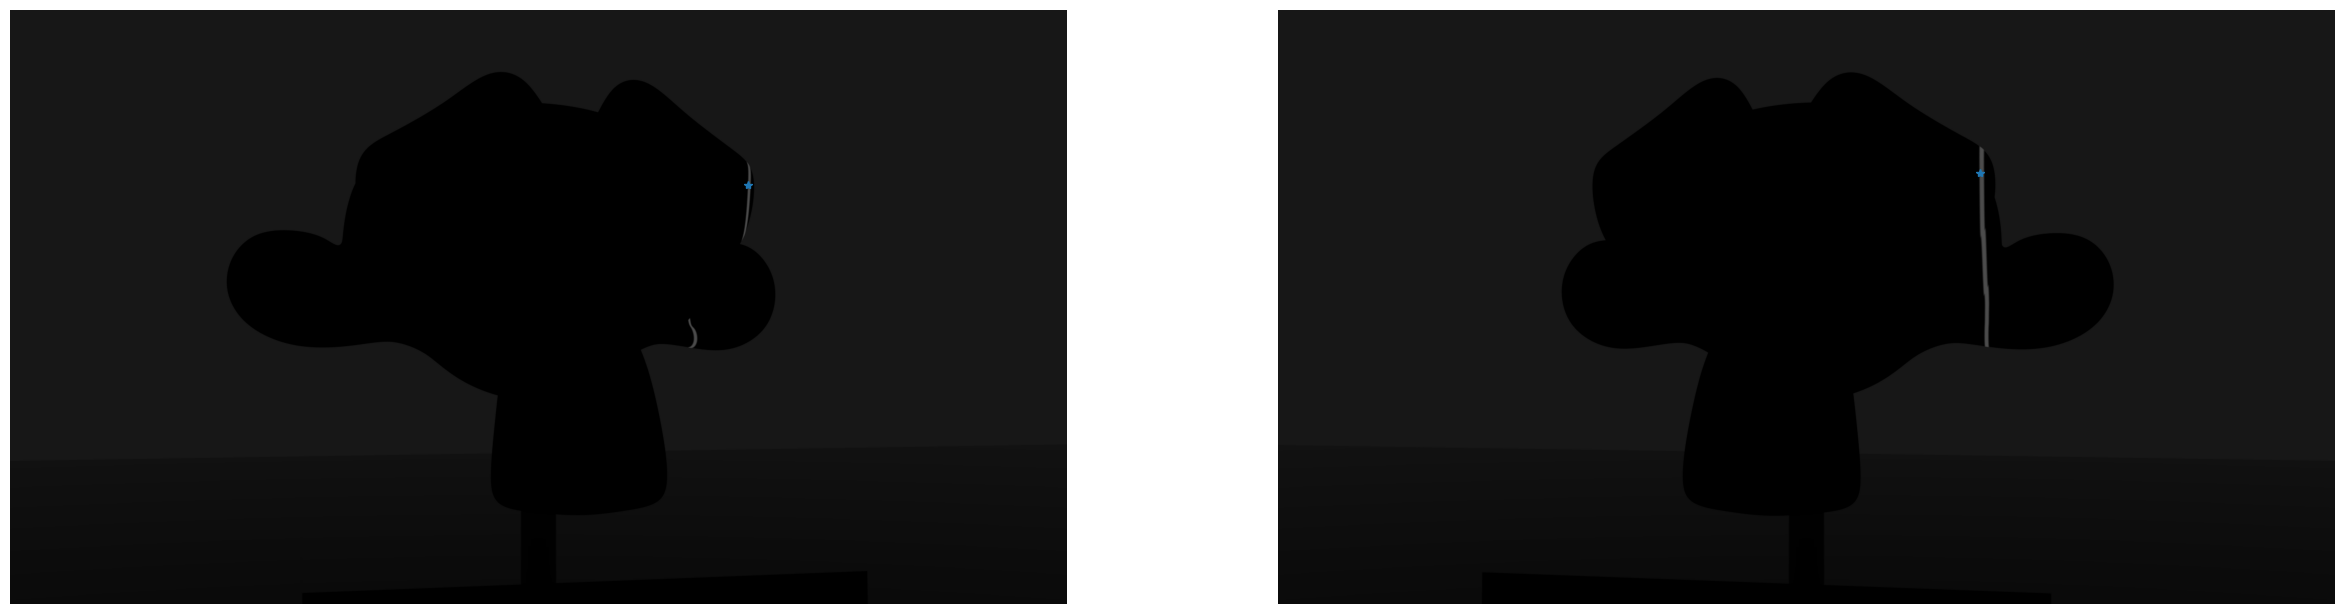

In [163]:
def plot_corresponding_points():
    """Plot un ou plusieurs points particulier qui correspond au même point dans la réalité de part et d'autre de chaque image
    """

    left_img = cv2.imread("scanLeft/0008.png",0)
    right_img = cv2.imread("scanRight/scan0008.png",0)

    left_img = cv2.cvtColor(left_img,cv2.COLOR_GRAY2BGR)
    right_img = cv2.cvtColor(right_img,cv2.COLOR_GRAY2BGR)

    plt.figure(figsize = (30,10))
    plt.subplot(1,2,1),plt.imshow(left_img)
    plt.plot(left_lasers[8][150][0], left_lasers[8][150][1], "*") # 8 eme pairs d'image, 150 eme points, 0 = x et 1 = y
    plt.axis("off")
    plt.subplot(1,2,2),plt.imshow(right_img)
    plt.plot(corresponding_right_points[8][150][0], corresponding_right_points[8][150][1], "*") # image de droite
    plt.axis("off")

plot_corresponding_points()

In [164]:
def triangulate_points():
    """Trianguler les points en partant de coordoonnées 3D du singe pour les ramener en coordonnées 2D

    Returns:
        real_points: Points projeté en 2D du singe à partir des points 3D
    """
    R1, R2, P1, P2, Q, roi_left, roi_right\
    = cv2.stereoRectify(left_calibration[0], left_calibration[1], right_calibration[0], right_calibration[1], (1920,1080), common_matrices[0], common_matrices[1]) # on trouve P1 et P2 les matrice de projection P1 c'est à gauche et P2 à droite
    real_points = []

    for index in range(0,26):
        if len(corresponding_right_points[index]) > 0:
            left_points = left_lasers[index].T.astype(np.float64) #la transposé des points gauche du laser
            right_points = corresponding_right_points[index].T.astype(np.float64) # la transposé des points droite du laser
            object_points_4D_hom = cv2.triangulatePoints(P1, P2, left_points, right_points)
            object_points = cv2.convertPointsFromHomogeneous(object_points_4D_hom.T)
            real_points.append(object_points)
    return real_points

real_points = triangulate_points()

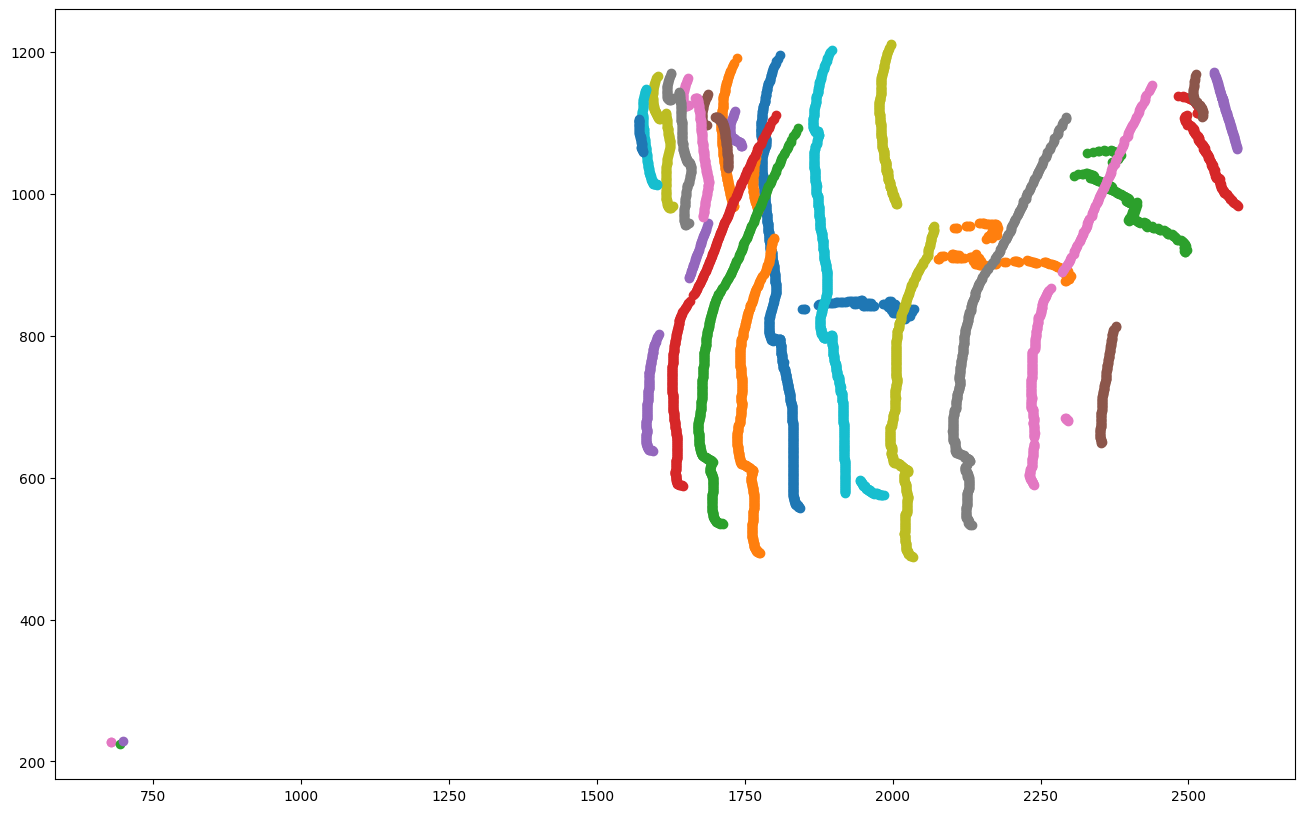

In [165]:
def plot_projected_point(real_points):
    """Plot les coordoonées 2D du singes sur un graphique

    Args:
        real_points: Ce sont les 2D projetés à partir des points 3D du singe
    """
    # print(object_points)
    plt.figure(figsize = (16,10))
    # plt.axis([1400, 2700, 450, 1250])
    # plt.axis("off")
    for line in real_points:
        reprojection_img_points, _ = cv2.projectPoints(line, left_calibration[2][1], left_calibration[3][1], left_calibration[0], left_calibration[1]) #pour trouver les points 2D a partir des points 3D , jaccobienne
        plt.plot(*zip(*reprojection_img_points.reshape(int(len(reprojection_img_points)),2)), "o", linewidth=0.01)
    plt.show()

plot_projected_point(real_points)